# ТЗ 

eid - id группы событий (показа и клика к нему) 
t - время 
user - id пользователя 
tn - тип события 
geo -  id региона 
cnethash - хеш от сети класса С, к которой принадлежит ip пользователя
devtype - тип устройства
brotype - тип браузера
bsize - id размера банера
siteid - id канала поставщика трафика
domhash - хеш от домена
urlhash - хеш от урла

В файле данные по одной рекламной кампании. Каждая строка - это клик (tn=1) или показ (tn=0). 
В кампании было накручено много кликов, не являющихся кликами реальных пользователей, осознанно кликавших по рекламе. 
Необходимо выявить такие клики любым удобным способом и составить краткое резюме проделанной работы с объяснением критериев выбора.
При возникновении вопросов относительно данных или выполнения задачи, пишите их контактному лицу по вакансии.

# Как мы можем понять, что клик накручен? 
### 1 Мы пользователю показываем рекламу и он всегда на нее нажимает или почти всегда (данный показатель можно даже в процентах посчитать) ВАЖНО!
### 2 Когда один и тот же пользователь кликает на банеры из разных регионов (сам по себе этот фактор не страшен, особенно сейчас, когда все используюв vpn, прокси и тд, но если этот фактор коррелирует тесно с Кол-вом кликов на банеры и тд, то можно начать подозревать данного юзера) НЕ ОСОБО ВАЖНО!
### 3 Клики от юзера приходят в одно и тоже время, или очень маленький промежуток ВАЖНО!
### 4 Я бы еще посмотрел на geo, если большая часть кликов приходит с одного гео, это повод задуматься ВАЖНО!
### 5 Я бы еще посмотрел на chethash, если большая часть кликов приходит с одного chethash, это тоже странно, возможно это прокси ВАЖНО!
### 6 siteid, если подумать логически, то поставщику трафика как бы выгодно давать нам ботов, чтобы мы смотрели на высокий уровень конверсии и с радостью заказывали трафик у этого поставщика, поэтому я бы также посмотрел на данный фактор ВАЖНО!
### 7 Такая же логика и для домена ВАЖНО!

In [71]:
import pandas as pd 
import numpy as np
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
from statsmodels.distributions.empirical_distribution import ECDF



# Считываем файл 

In [72]:
df = pd.read_csv(r"C:\Users\Sasha\OneDrive\Рабочий стол\тестовое младший аналитик\test_data.tsv", sep = "\t")

In [73]:
df.head(2)

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
0,347854231724,1050848,21,0,3818162082,8335634595980108828,2,2,1642713892,1732823002,17261330804588317013,16521739535555380904
1,329455126064,694606,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044


# Перед тем как начать работу непосредственно с ТЗ, я хочу немного познакомиться с данными (провести развыдывательный анализ)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48672 entries, 0 to 48671
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   eid       48672 non-null  int64 
 1   t         48672 non-null  int64 
 2   user      48672 non-null  int64 
 3   tn        48672 non-null  int64 
 4   geo       48672 non-null  int64 
 5   cnethash  48672 non-null  uint64
 6   devtype   48672 non-null  int64 
 7   brotype   48672 non-null  int64 
 8   bsize     48672 non-null  int64 
 9   siteid    48672 non-null  int64 
 10  domhash   48672 non-null  uint64
 11  urlhash   48672 non-null  uint64
dtypes: int64(9), uint64(3)
memory usage: 4.5 MB


### Сразу заметим что все данные в таблице заполнены и не встречается null значений, плюс нам не нужно менять формат у столбцов, что также упрощает задачу, проверим теперь дубликаты 

In [75]:
# Проверяем дубли по всей таблице 
df[df.duplicated(keep=False)]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash


In [76]:
# Посмотрим дубли по юзерам
df[df.duplicated(subset='user')]

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash
2,329455254926,694659,36,0,3818162082,2563013194488493467,3,2,2286540757,673473971,8781226038565509786,14273372146021722044
3,329455273798,694596,36,0,3818162082,2563013194488493467,3,2,3529439892,673473971,8781226038565509786,14273372146021722044
4,329455293738,694608,36,0,3818162082,2563013194488493467,3,2,390304810,673473971,8781226038565509786,14273372146021722044
8,320411433357,515262,148,0,3864597734,9857242284640379126,3,9,3529439892,3312146801,15469158373442651496,18110395686207991474
10,297366904396,16309,162,0,2169085419,8888378963647691173,3,2,4059410016,2854608146,12397643822621642061,17247241689397869523
...,...,...,...,...,...,...,...,...,...,...,...,...
48663,344718117547,980909,99892,0,239476928,17923180725687075424,2,2,4059410016,1732823002,8226252734070597606,501443720760815850
48665,4022514261,100107,99952,0,3954886488,15378092533632864638,2,2,390304810,1732823002,8417199575432949344,6470467525884367406
48666,4023395323,100124,99952,0,3954886488,15378092533632864638,2,2,390304810,1732823002,8417199575432949344,6470467525884367406
48670,323106589352,557496,99995,0,2960729952,15043720182730569642,3,2,3529439892,673473971,17190617809738632834,17743323135665871600


### Делаем вывод что у нас либо есть база юзеров, которым мы показываем нашу рекламу, либо юзер заходя на наш сайт, видит сразу несколько рекламных постов нашего агенства 
### Посмотрим, сколько у нас уникальных юзеров тогда 

In [77]:
df.user.nunique()

4421

### Еще интересно посмотреть процентное соотношение того, сколько у нас конверсия, с учетом того, что была накрутка

In [78]:
df.tn.value_counts(normalize = True)

tn
0    0.968216
1    0.031784
Name: proportion, dtype: float64

# Окей, мы видим, что конверсия 3,18%, теперь наша задача понять, как из этиъ 3,18% выявить накрученные клики 

In [79]:
# Возьмем только данные, где каждая строка содержит клик
df_1 = df[df.tn == 1]

# Начнем работу

# Кол-во кликов по юзеру деленное на общее число показов 

In [80]:
click_times = df_1.groupby(df.user)['tn'].count().sort_values(ascending=False).reset_index(name='click_advert')

df_1 = df_1.merge(right = click_times, on = "user", how = "left")
df_1.click_advert.fillna(0)

0       1
1       3
2       3
3       3
4       1
       ..
1542    2
1543    2
1544    1
1545    1
1546    1
Name: click_advert, Length: 1547, dtype: int64

In [81]:
show_times = df.groupby(df.user)['tn'].count().sort_values(ascending=False).reset_index(name='show_cnt')

In [82]:
# Сразу добавим эту колоку в таблицу
df_1 = df_1.merge(right = show_times, on = "user", how = "left")
df_1.show_cnt.fillna(1)

0        3
1       24
2       24
3       24
4       15
        ..
1542    34
1543    34
1544     8
1545     2
1546     3
Name: show_cnt, Length: 1547, dtype: int64

In [83]:
user_metrics = click_times.merge(right=show_times, on = 'user', how = "left")
user_metrics.fillna(0)

,user,click_advert,show_cnt
0,29537,47,479
1,4016,34,1219
2,16618,32,325
3,32449,32,339
4,9471,28,279
...,...,...,...
374,99209,1,1
375,207,1,3
376,99334,1,8
377,99649,1,2


In [84]:
user_metrics['click_rate%'] = ((user_metrics['click_advert'] / user_metrics['show_cnt']) * 100).round(2)

In [85]:
df_1 = df_1.merge(right = user_metrics[["user", 'click_rate%']], on = "user", how = "left")

# Посмотрим на промежуток во времени, как приходят клики

In [19]:
check_time = df_1[["user", "t"]]
check_time["converted_time"] = pd.to_datetime(check_time.t, unit="ms")

C:\Users\Sasha\AppData\Local\Temp\ipykernel_18992\1658862467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  check_time["converted_time"] = pd.to_datetime(check_time.t, unit="ms")


### Теперь что я хочу сделать? Я хочу применить сюда оконную функцию как в SQL, я сгруппирую данные по user и отсортирую по дате, а после буду вычитать из текущего времени прошлое и тд

In [20]:
check_time = check_time.sort_values(["user","converted_time"])
check_time.head(2)
check_time["time_diff"] = check_time.groupby("user")["converted_time"].diff()

##### Я тут понял, что зря переводил все во время, мне ж теперь самому не удобно смотреть на результаты, поэтому чтобы не изобретать велосипед, проделаем эти же шаги, но уже с t, вместо converted_time

In [21]:
check_time = check_time.sort_values(["user","t"])
check_time["time_diff_right"] = check_time.groupby("user")["t"].diff()

## Этот результат куда лучше, теперь выберем время после которого мы будем говорить, что клик был подозрительный и это накрутка, давайте скажем, что это менее 0.5 секунд

In [22]:
t = 0.5 # кол-во секунд
strange_time = check_time[check_time.time_diff_right <= (t * 1000)]
strange_time.drop_duplicates(inplace=True)
strange_time.user.unique()

C:\Users\Sasha\AppData\Local\Temp\ipykernel_18992\2940199965.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  strange_time.drop_duplicates(inplace=True)


array([  363,  1561,  1636,  1971,  2355,  3443,  4016,  5161,  5253,
        5274,  5999,  6886,  8665,  9471, 11209, 11323, 11783, 13191,
       14161, 15400, 16213, 16618, 16957, 17148, 17204, 17705, 18006,
       18870, 19764, 20966, 21667, 22111, 23031, 23344, 23536, 24354,
       25840, 26069, 26905, 27122, 27686, 28073, 29267, 29537, 30545,
       31483, 32324, 32449, 34125, 34170, 35173, 35721, 36431, 37453,
       37938, 38637, 39836, 40023, 40343, 40678, 41735, 44375, 44440,
       45726, 45811, 46768, 48658, 49610, 50036, 51247, 52185, 52865,
       52906, 54098, 55221, 56031, 56615, 57296, 57723, 58842, 59036,
       59373, 59605, 60464, 62291, 62888, 64280, 67198, 67263, 68001,
       68509, 69762, 70114, 72225, 72687, 73065, 73979, 74276, 76018,
       76300, 79089, 81793, 81949, 82226, 83186, 83725, 87326, 88570,
       89427, 89781, 90109, 90384, 90418, 90647, 90737, 91887, 92078,
       93035, 93673, 94245, 94894, 95041, 96440, 96619, 97629, 97935,
       98931])

In [23]:
check_time["flag_time"] = check_time.user.isin(strange_time.user).astype(int)
check_time["flag_time"] = check_time.flag_time.fillna(0)

In [24]:
# И сразу уберем дубли отсюда 
check_time[check_time.duplicated()]
check_time.drop_duplicates(inplace = True)

In [25]:
f = check_time["user"].unique()

In [26]:
df_1['flag_time'] = df_1.user.isin(f).astype(int)
df_1['flag_time'] = df_1.flag_time.fillna(0)

# Проверим geo по юзерам, кто часто кликал на банеры 

In [27]:
t = df_1.value_counts(subset = "geo").reset_index(name = "geo_proportions")

### Отсюда можно начать делать поспешный вывод о том, что много подозрительной активности идет из определенных регионов, значит нужно к трафику оттуда относиться с осторожностью. Это в целом правильный ход, но перед этим, нам нужно проверить процентное соотношение, сколько трафика с этих регионов пришло, и сколько мы подкрасили как подозрительный

In [28]:
f = df[df.tn == 0]

In [29]:
f = f.value_counts(subset = "geo").reset_index(name = "geo_0")

In [30]:
t = t.merge(right = f, on = "geo", how = "inner")

In [31]:
# И теперь также давайте сделаем рейтинг по geo
t["geo_suspicious_per"] = t["geo_proportions"] / t["geo_0"]

In [32]:
t.sort_values(by = "geo_suspicious_per", ascending=False)

,geo,geo_proportions,geo_0,geo_suspicious_per
49,2972730849,3,12,0.250000
45,1260189617,3,14,0.214286
34,3330446895,11,99,0.111111
17,1683184212,29,285,0.101754
37,460904980,5,55,0.090909
...,...,...,...,...
48,1642713892,3,235,0.012766
50,290091958,2,192,0.010417
55,3507599847,2,200,0.010000
56,2862123161,2,215,0.009302


In [33]:
df_1 = df_1.merge(right = t[["geo", "geo_suspicious_per"]], on = "geo", how = "inner")
df_1.geo_suspicious_per.fillna(0)

0       0.024855
1       0.062257
2       0.062257
3       0.062257
4       0.048319
          ...   
1542    0.044444
1543    0.044444
1544    0.045455
1545    0.025636
1546    0.030459
Name: geo_suspicious_per, Length: 1547, dtype: float64

# Смотрим на chethash

In [34]:
d = df_1.value_counts(subset = "cnethash").reset_index(name = "chethash_proportions")

# Опять же, будем сравнивать в процентном соотношении

In [35]:
f = df[df.tn == 0]

In [36]:
f = f.value_counts(subset="cnethash").reset_index(name = "cnethash_0")

In [37]:
d = d.merge(right = f, on = "cnethash", how = "inner")

In [38]:
d["cnethash_perc"] = d["chethash_proportions"] / d["cnethash_0"]

In [39]:
d = d.sort_values(by = "cnethash_perc", ascending= False)

In [40]:
d[~d.cnethash_0.isin([1,2,3,4,5,6,7,8,9,10])]

,cnethash,chethash_proportions,cnethash_0,cnethash_perc
3,9767258174204031868,21,28,0.750000
17,6406880047108242353,12,27,0.444444
12,1274834311847337075,14,42,0.333333
119,2385011738004893530,4,14,0.285714
49,1274416185440514140,7,25,0.280000
...,...,...,...,...
368,12379128262166757439,1,139,0.007194
155,10083374155754676052,3,426,0.007042
275,5265031842285981700,1,156,0.006410
281,8152637166701363697,1,227,0.004405


# Смотрим на поставщика трафика siteid

In [41]:
d = df_1.value_counts(subset = "siteid").reset_index(name = "proportion_siteid")

# Опять же, будем сравнивать в процентном соотношении

In [42]:
f = df[df.tn == 0]

In [43]:
f = f.value_counts(subset="siteid").reset_index(name = "siteid_0")

In [44]:
d = d.merge(right = f, on = "siteid", how = "inner")

In [45]:
d["siteid_perc"] = d["proportion_siteid"] / d["siteid_0"]

In [46]:
d

,siteid,proportion_siteid,siteid_0,siteid_perc
0,1732823002,1101,18108,0.060802
1,673473971,211,7051,0.029925
2,2019279739,167,18933,0.008821
3,3312146801,53,1753,0.030234
4,2854608146,10,1051,0.009515
5,251638358,5,187,0.026738


In [47]:
df_1 = df_1.merge(right = d[["siteid", "siteid_perc"]], on = "siteid", how = "inner")

# Последнее на что смотрим на домен 

In [48]:
d = df_1.value_counts(subset = "domhash").reset_index(name = "proportion_domhash")

In [49]:
f = df[df.tn == 0]

In [50]:
f = f.value_counts(subset="domhash").reset_index(name = "domhash_0")

In [51]:
d = d.merge(right = f, on = "domhash", how = "inner")

In [52]:
d["domhash_perc"] = d["proportion_domhash"] / d["domhash_0"]

In [53]:
df_1 = df_1.merge(right = d[["domhash", "domhash_perc"]], on = "domhash", how = "inner")

In [54]:
d = d[~d.domhash_0.isin([1, 2, 3, 4, 5])]
d = d.sort_values(by = "domhash_perc", ascending= False)
d.head(20)

,domhash,proportion_domhash,domhash_0,domhash_perc
9,7097386544750852276,29,48,0.604167
26,15112805901111966778,6,14,0.428571
16,16759061825393208232,9,25,0.360000
81,10922377396575170130,2,6,0.333333
53,5694199968753817350,3,12,0.250000
73,6953334576071830371,2,8,0.250000
31,6710524849508083493,6,26,0.230769
54,14630686440316387238,3,14,0.214286
46,718179210786408666,4,20,0.200000
79,14253219143605151993,2,11,0.181818


# Просуммируем что мы имеем

## 1 click_rate% - Эта метрика уже важнее. Она показывает соотношение кликов к показам рекламы
## 2 flag_time - Тоже важная метрика, которая показает насколько часто юзер кликал по банерам
## 3 geo_proportions - Показывает из какого региона пользователь и в каком соотношении пользователи находятся в даннном регионе
## 4 chethash_proportions - Показывает какая сеть у пользователя и в каком соотношении эти данные 
## 5 proportion_siteid - Поставщик трафика и в каком соотношении был закуплен трафик у данного поставщика 
## 6 proportion_domhash - Такая же метрика как 5, но с доменом 

# Начнем отсекать данные и искать накрутку 

### Отсекаем пользователей по clickrate

In [55]:
df_1.head()

,eid,t,user,tn,geo,cnethash,devtype,brotype,bsize,siteid,domhash,urlhash,click_advert,show_cnt,click_rate%,flag_time,geo_suspicious_per,siteid_perc,domhash_perc
0,299522852624,72336,207,1,1539789858,1914105787300337336,2,2,3529439892,1732823002,6914246990831417846,7225540168013982636,1,3,33.33,1,0.024855,0.060802,0.040000
1,48923341882,1135684,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,3,24,12.50,1,0.062257,0.060802,0.030284
2,48925603446,1135717,363,1,496411576,618208581979777446,2,2,3529439892,1732823002,7589661441840127586,13552381492480484636,3,24,12.50,1,0.062257,0.060802,0.030284
3,52173416312,1208840,363,1,496411576,618208581979777446,2,2,4059410016,1732823002,5398870908427309388,7145879351273368377,3,24,12.50,1,0.062257,0.060802,0.089786
4,16010841443,376051,920,1,390304810,2339536559139938629,2,2,2286540757,673473971,15630579387847758071,15271819797260967753,1,15,6.67,1,0.048319,0.029925,0.065574


In [56]:
z = df_1[["user","click_advert","show_cnt","click_rate%", "flag_time"]].sort_values(by = "click_rate%",ascending=False).reset_index(drop=True)
# Сразу почистим дубликаты
z.drop_duplicates(inplace=True)

## Сразу определим после какого значения clickrate мы будем говорить, что скорее всего накрутка + Для большей уверенности будем смотреть по юзерам, где время между переходами по банерам маленькое flag_time == 1
## Для этого давайте изначально уберем все значения где show_cnt менее 30

In [57]:
z = z[(z.show_cnt > 30) & (z.flag_time == 1)].sort_values(by = "click_rate%", ascending=False)

In [58]:
z.head()

,user,click_advert,show_cnt,click_rate%,flag_time
157,56615,7,35,20.00,1
172,5253,10,51,19.61,1
185,5161,8,43,18.60,1
193,92078,6,33,18.18,1
203,45726,11,65,16.92,1


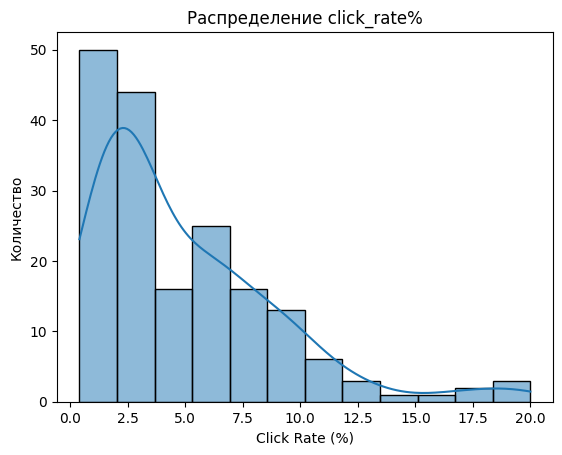

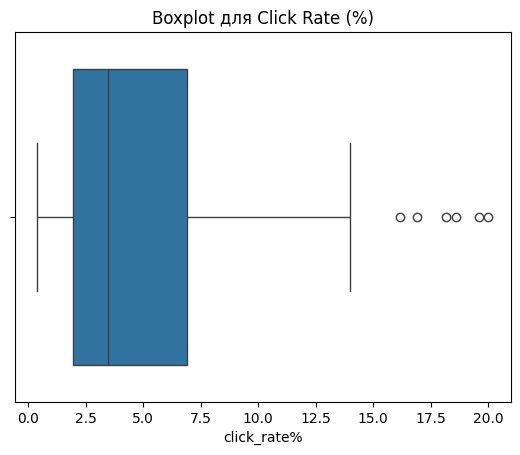

In [59]:
sns.histplot(z['click_rate%'], kde=True)
plt.title('Распределение click_rate%')
plt.xlabel('Click Rate (%)')
plt.ylabel('Количество')
plt.show()

#Boxplot
sns.boxplot(x=z['click_rate%'])
plt.title('Boxplot для Click Rate (%)')
plt.show()

## Во первых, мы можем убрать все значения где click_rate более 14
## “Значение 14 превышает верхнюю границу (Q3 + 1.5 * IQR) для выбросов, что делает его статистически аномальным.”

## Также мы видим 3 пика данных, в области 0, 2.5, 6, значит, мы можем сделать вывод о том, что после этих значений, у нас начинается накрутка и все данные, которые вышли за предел скажем 7,5, являются накруткой


In [60]:
threshold = 6
percentage_above = (z['click_rate%'] > threshold).mean() * 100
print(f"Процент значений выше {threshold}%: {percentage_above:.2f}%")

Процент значений выше 6%: 31.67%


In [61]:
threshold = 7
percentage_above = (z['click_rate%'] > threshold).mean() * 100
print(f"Процент значений выше {threshold}%: {percentage_above:.2f}%")

Процент значений выше 7%: 24.44%


### В рамках теста, давайте скажем, что за порог берем 7% 

In [62]:
suspected_users = z[z["click_rate%"] > 7]

In [63]:
suspected_users = np.array(suspected_users.user.unique())

In [64]:
suspected_users

array([56615,  5253,  5161, 92078, 45726, 83725,  1636, 90418, 45811,
       74276, 27122, 58842, 73065,  1492, 64844, 11783,  9471, 16618,
        5999, 29537, 46768, 83186, 32449, 59437, 31043, 22111, 70114,
       26069, 59036, 72225, 23344, 88570, 17148, 51247, 59605, 68001,
       47779, 98471, 41735, 81793, 36983, 17705, 37938, 44375])

# Этих пользователей мы считаем накрутчиками, поэтому отметим их в основной таблице и заодно посмотрим что между ними общего

In [ ]:
# Смотрим на domhash
df["suspected_users"] = df["user"].isin(suspected_users).astype(int)
a = df[(df.suspected_users == 1) & (df.tn == 1 )]
b = df[(df.suspected_users == 1) & (df.tn == 0 )]
a = a.groupby("domhash")["user"].count().sort_values(ascending=False).reset_index(name = "1")
b = b.groupby("domhash")["user"].count().sort_values(ascending=False).reset_index(name = "0")
b = b.merge(right = a, on = "domhash", how = "inner")
b.drop_duplicates(inplace=True)
b["data"] = b["1"] / b["0"] 
b = b[~b["0"].isin(np.array(range(20)))]
b.sort_values(by = "data", ascending=False).reset_index(drop=True)

In [ ]:
# Смотрим на geo
a = df[(df.suspected_users == 1) & (df.tn == 1 )]
b = df[(df.suspected_users == 1) & (df.tn == 0 )]
a = a.groupby("geo")["user"].count().sort_values(ascending=False).reset_index(name = "1")
b = b.groupby("geo")["user"].count().sort_values(ascending=False).reset_index(name = "0")
b = b.merge(right = a, on = "geo", how = "inner")
b.drop_duplicates(inplace=True)
b["data"] = b["1"] / b["0"] 
b = b[~b["0"].isin(np.array(range(20)))]
b.sort_values(by = "data", ascending=False).reset_index(drop=True)

In [ ]:
# Смотрим на cnethash
a = df[(df.suspected_users == 1) & (df.tn == 1 )]
b = df[(df.suspected_users == 1) & (df.tn == 0 )]
a = a.groupby("cnethash")["user"].count().sort_values(ascending=False).reset_index(name = "1")
b = b.groupby("cnethash")["user"].count().sort_values(ascending=False).reset_index(name = "0")
b = b.merge(right = a, on = "cnethash", how = "inner")
b.drop_duplicates(inplace=True)
b["data"] = b["1"] / b["0"] 
b = b[~b["0"].isin(np.array(range(20)))]
b.sort_values(by = "data", ascending=False).reset_index(drop=True)

In [69]:
p = df[df.suspected_users == 0]
p["tn"].value_counts(normalize=True)

tn
0    0.975866
1    0.024134
Name: proportion, dtype: float64

Text(0, 0.5, '')

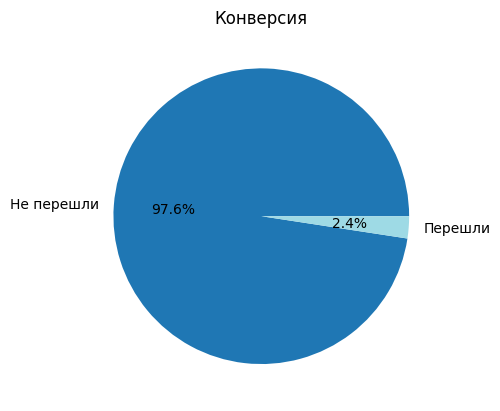

In [70]:
ax = p.tn.value_counts(normalize=True).plot.pie(title="Конверсия", labels=["Не перешли", "Перешли"], autopct='%1.1f%%', cmap='tab20')
ax.set_ylabel('')

# Выводы (Консервативные)
## Изначально наша конверсия, с учетом накрутки была 3,18%, после нормализации значений, мы получили, что истинная конверсия составляет 2,4%

## На какие показатели мы смотрили, чтобы понять, что клик может быть накрученный 
## 1 Мы смотрим на click rate каждого пользователя, мы убираем все значения где click rate более 7,5% и сразу же мы  смотрим на время за которое пользователь кликнул на рекламу, в нашем случае это менее 0,5 секунд

### Таким образом у нас получилось 44 юзера, которых мы заподозрили в спаме [56615,  5253,  5161, 92078, 45726, 83725,  1636, 90418, 45811, 74276, 27122, 58842, 73065,  1492, 64844, 11783,  9471, 16618, 5999, 29537, 46768, 83186, 32449, 59437, 31043, 22111, 70114, 26069, 59036, 72225, 23344, 88570, 17148, 51247, 59605, 68001, 47779, 98471, 41735, 81793, 36983, 17705, 37938, 44375]
## Плюс я нашел интересный факт связанный с domhash В 23.5% suspected users приходили с этого домена (8016818914374733663)

# Выводы (более агрессивные)

# Тут мы смотрим на время реагирования на рекламу, если оно менее 0,02 сек, мы сразу блокируем всех этих пользователей
# Плюс, если click rate более 8, мы также сразу блокируем этих пользователей 

# Так у нас тоже получилось, что истинная конверсия 2,4%. Можно предположить что это настоящее число конверсии и мы все верно просчитали 

In [ ]:
check_time = df_1[["user", "t"]]
check_time.head(2)
check_time["converted_time"] = pd.to_datetime(check_time.t, unit="ms")
check_time.head()
check_time = check_time.sort_values(["user","converted_time"])
check_time.head(2)
check_time["time_diff"] = check_time.groupby("user")["converted_time"].diff()

check_time = check_time.sort_values(["user","t"])
check_time["time_diff_right"] = check_time.groupby("user")["t"].diff()

t = 0.02 # кол-во секунд
strange_time = check_time[check_time.time_diff_right <= (t * 1000)].reset_index()
strange_time.drop_duplicates(inplace=True)


In [87]:
suspected_users = np.array(strange_time.user.unique())
suspected_users

array([ 1971,  5253, 16618, 23344, 30545, 35721, 37453, 40343, 57723,
       58842, 59605, 67263, 76018, 83725, 87326, 90418, 91887, 93035])

In [88]:
# Блокируем этих юзеров и трафик от них считаем накрученным 
df = df[~df.user.isin(suspected_users)]

In [89]:
df_1 = df_1[~df_1.show_cnt.isin(np.array(range(30)))]
df_1 = df_1[df_1["click_rate%"] > 8]
df_1 = df_1.user.unique()

In [90]:
df = df[~df.user.isin(df_1)]

Text(0, 0.5, '')

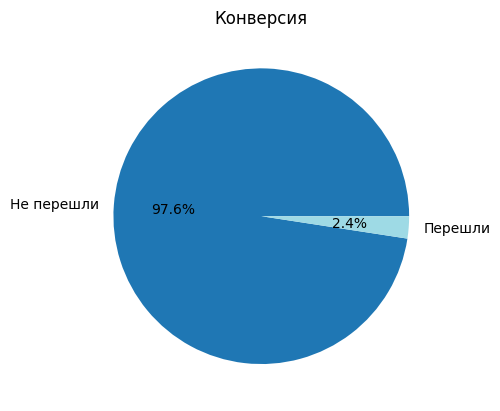

In [91]:
ax = df.tn.value_counts(normalize=True).plot.pie(title="Конверсия", labels=["Не перешли", "Перешли"], autopct='%1.1f%%', cmap='tab20')
ax.set_ylabel('')